# 시각화 튜토리얼
- 초기 모델은 실험 1의 모델과 파라미터를 이용하였습니다
- eigenCAM의 성능이 우수한 것을 볼 수 있지만 일부 사진에서는 다른 캠이 우수한 것을 확인할 수 있습니다.

In [7]:
from utils import visualization
from models import EfficientB0
from torch import nn
import torch
import os
from matplotlib import pyplot as plt

# 식물 라벨 가져오기
- 식물명과 폴더명이 다르기 때문에 이를 매칭시키기 위해서 json 파일을 가져옵니다

In [2]:
import json

with open("/home/files/datasets/plantnet_300K/plantnet300K_species_id_2_name.json", 'r') as f:

    json_data = json.load(f)

print(json.dumps(json_data) )

{"1355868": "Lactuca virosa L.", "1355920": "Pelargonium capitatum (L.) L'H\u00e9r.", "1355932": "Pelargonium graveolens L'H\u00e9r.", "1355936": "Cirsium arvense (L.) Scop.", "1355937": "Cirsium vulgare (Savi) Ten.", "1355955": "Pelargonium odoratissimum (L.) L'H\u00e9r.", "1355959": "Pelargonium peltatum (L.) L'H\u00e9r.", "1355961": "Pelargonium quercifolium (L. f.) L'H\u00e9r.", "1355978": "Pelargonium zonale (L.) L'H\u00e9r.", "1355990": "Mercurialis annua L.", "1356003": "Phyllanthus tenellus Roxb.", "1356022": "Hypericum perforatum L.", "1356037": "Egeria densa Planch.", "1356055": "Ibicella lutea (Lindl.) Van Eselt.", "1356075": "Tradescantia fluminensis Vell.", "1356076": "Tradescantia zebrina Heynh. ex Bosse", "1356111": "Lamium amplexicaule L.", "1356126": "Lavandula dentata L.", "1356138": "Striga asiatica (L.) Kuntze", "1356257": "Melilotus albus Medik.", "1356278": "Trifolium fragiferum L.", "1356279": "Asystasia gangetica (L.) T. Anderson", "1356309": "Nymphaea nouchali 

# 모델 가져오기
- 모델은 EfficientB0, 파라미터는 실험1번 결과값을 가져왔습니다

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = EfficientB0(1081, loss_fn=nn.CrossEntropyLoss())
model.load('/home/files/experiments/exp_set1/checkpoints/checkpoint_fixed.pt')
model=model.to(device)
model.patch_embedding

Using cuda device


Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU(inplace=True)
  (3): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
    )
    (1): 

## 플렌트넷 폴더 라벨을 가져왔으니 모델이 인덱싱한 라벨링(오름차순 정렬)으로 카테고리를 정렬시킵니다

In [4]:
# PlantNet 라벨을 가져오자
test_path="/home/files/datasets/plantnet_300K/images/test"

labels_list=[sub for sub in os.listdir(test_path) if os.path.isdir(os.path.join(test_path, sub))]
labels_list=sorted(labels_list)
categories_list=[0]*len(labels_list)
for i in range(len(labels_list)):
    if labels_list[i] in list(json_data.keys()):
        categories_list[i]=json_data[labels_list[i]] # 라벨링과 카테고리 리스트를 따로 만듦
#len(labels_list)
len(categories_list)

1081

In [5]:
#테스트용 이미지 땡겨오기 -> find_label함수는 우리 작업 환경에서만 씀
def find_label(plantname):
    global json_data,test_path,labels_list
    #1.식물이름을 받으면 그에 맞는 식물파일로 변환을 먼저 시켜줘야된다.(파일이름이 라벨로 되어있으므로)
    plant_label=None
    for item in json_data.items():
        if item[1]==plantname:
            plant_label=item[0]
            break
    return plant_label

## 종류별 캠 측정 튜토리얼(캠은 5가지 종류만 일단 사용하였습니다)

Lactuca virosa L.


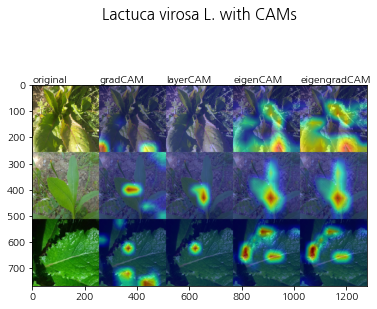

Pelargonium capitatum (L.) L'Hér.
이미지의 갯수가 입력값보다 적어서 폴더 내 모든 사진을 받아옵니다. 사진 갯수: 1


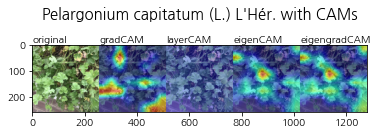

Pelargonium graveolens L'Hér.


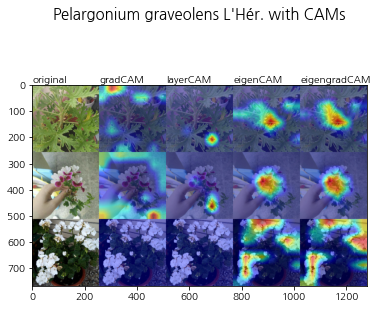

In [19]:
for plant in categories_list[:3]: #0번 부터 2번까지의 카테고리종의 식물을 가져옵니다
    
    plant_label=find_label(plant)
    path=os.path.join(test_path,plant_label)
    print(plant)
    label=labels_list.index(plant_label)
    original_imgs=visualization.bring_imgs(path,3)
    shape=(len(original_imgs),5)
    
    testlist=visualization.printCAM(label,original_imgs,model,[model.patch_embedding])

    vstable=visualization.make_table(testlist,shape) #images 는 이미지들 담겨있는 리스트임
    plt.imshow(vstable)
    plt.title(plant +' with CAMs',y=1.3,fontsize=15)
    
    word=['original','gradCAM','layerCAM','eigenCAM','eigengradCAM']
    for i in range(5):
        plt.text(256*i,-10,word[i])
    
    plt.show()

## 캠의 성능확인 튜토리얼(eigenCAM이 성능이 우수하여 이를 사용하였습니다)
- 특징이 뚜렷한 사진(예를들어 꽃하나가 큼지막하게 있다던지)들은 detection을 꽤나 잘해주고 있음을 확인하였습니다

Lactuca virosa L.


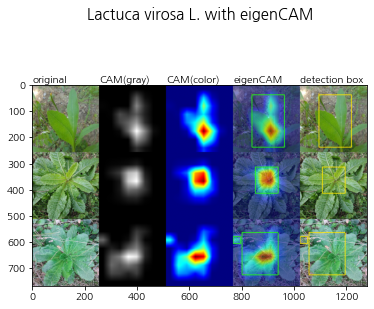

Pelargonium capitatum (L.) L'Hér.
이미지의 갯수가 입력값보다 적어서 폴더 내 모든 사진을 받아옵니다. 사진 갯수: 1


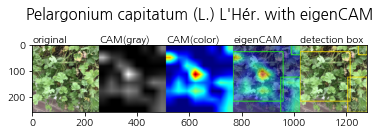

Pelargonium graveolens L'Hér.


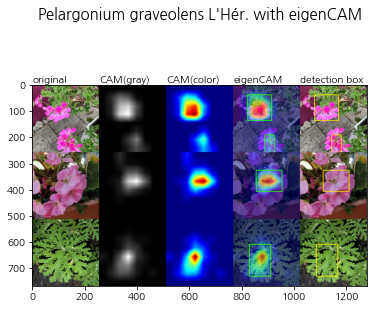

Cirsium arvense (L.) Scop.


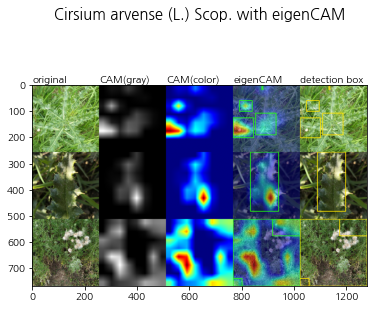

Cirsium vulgare (Savi) Ten.


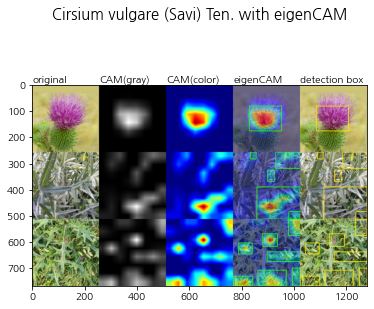

In [20]:
for plant in categories_list[:5]: #0~4번까지 맨앞 5종의 식물을 가져옵니다.
    plant_label=find_label(plant)
    path=os.path.join(test_path,plant_label)
    print(plant)
    
    label=labels_list.index(plant_label)
    original_imgs=visualization.bring_imgs(path,3)
    shape=(len(original_imgs),5)
    
    #CAM 이미지를 하나의 리스트로 반환
    testlist2=visualization.diverse_CAM(label,original_imgs,model,'eigenCAM',[model.patch_embedding]) 
    
    #리스트내 들어있는 이미지를 테이블형식으로 정렬
    vstable=visualization.make_table(testlist2,shape)
    
    plt.imshow(vstable)
    plt.title(plant +' with eigenCAM',y=1.3,fontsize=15)

    word=['original','CAM(gray)','CAM(color)','eigenCAM','detection box']
    for i in range(5):
        plt.text(256*i,-10,word[i])
    plt.show()
    #plt.savefig('withBox'+str(plant_label)+'.png',dpi=256)